# File Setup

In [1]:
import geopandas as gpd
import shapely
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import fiona
import scipy
import pyarrow
import folium
from pyproj import Transformer
import branca 
from branca.colormap import LinearColormap
import rasterio
from folium.plugins import HeatMap
import matplotlib.colors as mcolors
import json

# Load one netcdf file to test

#### Load rain data 

In [2]:
rain_regions_dict = {
    3:'Waikato Region',
    6:"Hawke's Bay Region",
    8:'Manawatū-Whanganui Region',
    13:'Canterbury Region'
}


In [3]:
df_rainfall = pd.read_csv('VCSN_Region_GNS.csv')

In [4]:
rainfall_mean_dict = {}

for region,group_region in df_rainfall.groupby('region_N'):
    if region not in (rain_regions_dict.keys()):
        continue
    for q,group in group_region.groupby('q5rain30'):
        rainfall_mean_dict.update({
            (rain_regions_dict[region],q):round(np.mean(group.Rain_sum30day),0)
        })

In [5]:
df_mean_rain = pd.DataFrame.from_dict(rainfall_mean_dict,orient='index')
df_mean_rain['region'] = [x[0] for x in df_mean_rain.index]
df_mean_rain['quintile'] = [x[1] for x in df_mean_rain.index]
df_mean_rain = df_mean_rain.rename(columns={0:'mean_precip'})
# df_mean_rain = df_mean_rain.pivot('quintile',columns='region')
# df_mean_rain.columns = [x[1] for x in df_mean_rain.columns]
# df_mean_rain.T
df_mean_rain

,mean_precip,region,quintile
"(Waikato Region, 1)",299.0,Waikato Region,1
"(Waikato Region, 2)",594.0,Waikato Region,2
"(Waikato Region, 3)",873.0,Waikato Region,3
"(Waikato Region, 4)",1247.0,Waikato Region,4
"(Waikato Region, 5)",1887.0,Waikato Region,5
"(Hawke's Bay Region, 1)",297.0,Hawke's Bay Region,1
"(Hawke's Bay Region, 2)",585.0,Hawke's Bay Region,2
"(Hawke's Bay Region, 3)",864.0,Hawke's Bay Region,3
"(Hawke's Bay Region, 4)",1212.0,Hawke's Bay Region,4
"(Hawke's Bay Region, 5)",1805.0,Hawke's Bay Region,5


#### Load ground water data 

In [6]:
gdf_base_sfo = gpd.read_parquet('for_shannon/hpm_base4sb/hpm_base4sb_streams_sfo.pqt')
gdf_base_sfo = gdf_base_sfo.to_crs(4326)
gdf_base_sfx = gpd.read_parquet('for_shannon/hpm_base4sb/hpm_base4sb_streams_sfx.pqt')
gdf_base_sfx = gdf_base_sfx.to_crs(4326)
xr_base = xr.open_dataset('for_shannon/hpm_base4sb/hpm_base4sb.nc')

In [7]:
gdf_dry_sfo = gpd.read_parquet('for_shannon/hpm_dry4sb/hpm_dry4sb_streams_sfo.pqt')
gdf_dry_sfo = gdf_dry_sfo.to_crs(4326)
gdf_dry_sfx = gpd.read_parquet('for_shannon/hpm_dry4sb/hpm_dry4sb_streams_sfx.pqt')
gdf_dry_sfx = gdf_dry_sfx.to_crs(4326)
xr_dry = xr.open_dataset('for_shannon/hpm_dry4sb/hpm_dry4sb.nc')

In [8]:
gdf_wet_sfo = gpd.read_parquet('for_shannon/hpm_wet4sb/hpm_wet4sb_streams_sfo.pqt')
gdf_wet_sfo = gdf_wet_sfo.to_crs(4326)
gdf_wet_sfx = gpd.read_parquet('for_shannon/hpm_wet4sb/hpm_wet4sb_streams_sfx.pqt')
gdf_wet_sfx = gdf_wet_sfx.to_crs(4326)
xr_wet = xr.open_dataset('for_shannon/hpm_wet4sb/hpm_wet4sb.nc')

In [9]:
xr_dry['hds'] = xr_dry.hds.mean('realization',skipna=True)
xr_base['hds'] = xr_base.hds.mean('realization',skipna=True)
xr_wet['hds'] = xr_wet.hds.mean('realization',skipna=True)

In [10]:
df_health_outcomes = pd.read_csv('simon_data_cleaned.csv')
df_health_outcomes = df_health_outcomes.replace('Manawat?-Whanganui Region','Manawatū-Whanganui Region')

In [11]:
df_health_outcomes = pd.merge(df_health_outcomes,df_mean_rain,left_on=['Region','rainfall_quintile'],right_on=['region','quintile'])

In [12]:
gdf_lgas = gpd.read_file('statsnz-regional-council-2020-generalised-SHP/regional-council-2020-generalised.shp')
gdf_lgas = gdf_lgas[gdf_lgas['REGC2020_1'].isin(['Waikato Region',"Hawke's Bay Region","Manawatū-Whanganui Region","Canterbury Region"])]
gdf_lgas = pd.merge(gdf_lgas,df_health_outcomes,left_on='REGC2020_1',right_on='Region')
gdf_lgas = gdf_lgas.to_crs(4326)

gdf_lgas_q4 = gdf_lgas[gdf_lgas.rainfall_quintile==4]
gdf_lgas_q5 = gdf_lgas[gdf_lgas.rainfall_quintile==5]

geojson_data_4  = gdf_lgas_q4.to_json()
geojson_data_5  = gdf_lgas_q5.to_json()

In [13]:
def style_function(feature):
    cmap = plt.cm.get_cmap('Reds')
    
    rgb_color = cmap(feature['properties']['risk_increase']/100)
    hex_color = mcolors.rgb2hex(rgb_color)
    
    return {'fillColor': hex_color, 'color': 'black', 'weight': 1, 'fillOpacity': 0.7}


In [14]:
def style_function_precip(feature):
    cmap = plt.cm.get_cmap('Blues')
    
    rgb_color = cmap((feature['properties']['mean_precip']-1000)/1000)
    hex_color = mcolors.rgb2hex(rgb_color)
    
    return {'fillColor': hex_color, 'color': 'black', 'weight': 1, 'fillOpacity': 0.7}


In [15]:
gpd.read_parquet('for_shannon/hpm_base4sb/hpm_base4sb_streams_sfo.pqt').__getattr__('crs')

<Projected CRS: EPSG:2193>
Name: NZGD2000 / New Zealand Transverse Mercator 2000
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: New Zealand - North Island, South Island, Stewart Island - onshore.
- bounds: (166.37, -47.33, 178.63, -34.1)
Coordinate Operation:
- name: New Zealand Transverse Mercator 2000
- method: Transverse Mercator
Datum: New Zealand Geodetic Datum 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

# Plotting

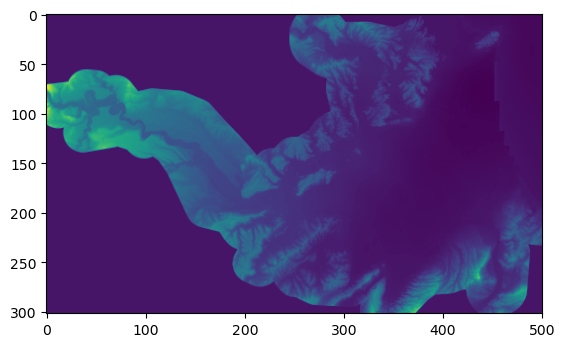

In [16]:
plt.imshow(xr_base.botm[1,:,:])

In [17]:
def regrid_and_normalise(xr_heads):
    x = xr_heads['x'].values.flatten()
    y = xr_heads['y'].values.flatten()
    top = xr_heads.hds[0,:,:].values.flatten()

    unflattened_x = np.reshape(x,(len(xr_heads.i),len(xr_heads.j)))
    unflattened_y = np.reshape(y,(len(xr_heads.i),len(xr_heads.j)))
    unflattened_z = np.reshape(top,(len(xr_heads.i),len(xr_heads.j)))

    xr_test = xr.Dataset({
        'hds':(('y','x'),unflattened_z)
               },
              coords={
            'y': unflattened_y[:, 0],
            'x': unflattened_x[0, :]
        })

    xr_test = xr_test.rio.write_crs(2193)

    # Create a new CRS in EPSG:4326 (WGS 84)
    target_crs = rasterio.crs.CRS.from_epsg(4326)

    xr_test = xr_test.astype(float)
    # Reproject the xarray dataset to EPSG:4326

    xr_test_2 = xr_test.rio.reproject("EPSG:4326")

    filtered_array = np.array((xr_test_2.where(xr_test_2<10000,np.nan).where(xr_test_2>0,np.nan)).hds)
    normalised_array = np.ma.masked_invalid(filtered_array)
    normalised_array = (normalised_array-normalised_array.min())/(normalised_array.max()-normalised_array.min())

    plt.imshow(normalised_array)
    
    return(xr_test_2,normalised_array,filtered_array)

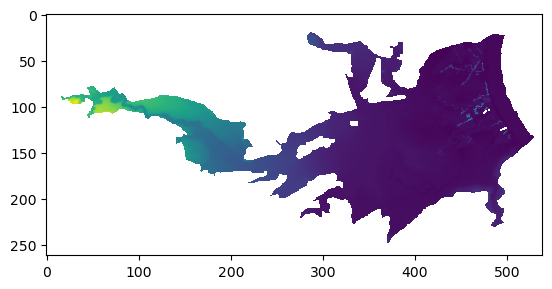

In [18]:
xr_base_regrid,normalised_base_array,base_filtered_array = regrid_and_normalise(xr_base)

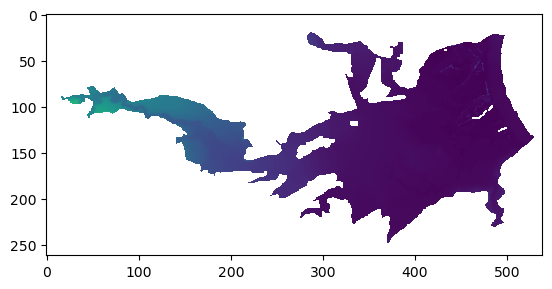

In [24]:
xr_dry_regrid,normalised_dry_array,dry_filtered_array = regrid_and_normalise(xr_dry)

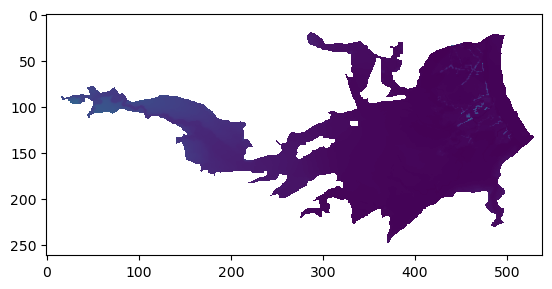

In [25]:
xr_wet_regrid,normalised_wet_array,wet_filtered_array = regrid_and_normalise(xr_wet)

# Health

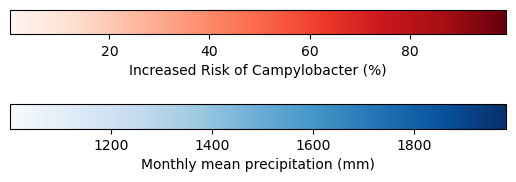

In [21]:
blue_cmap = plt.cm.get_cmap('Blues')
orange_cmap = plt.cm.get_cmap('Reds')

fig = plt.figure()
plt.imshow(np.random.random((10,10))*1000+1000,origin='lower',cmap=blue_cmap,interpolation='nearest')
cbar_blue = plt.colorbar(orientation='horizontal')
plt.imshow(np.random.random((10,10))*100,origin='lower',cmap=orange_cmap,interpolation='nearest')
cbar_orange = plt.colorbar(orientation='horizontal')
ax = plt.gca()        
ax.remove()
cbar_blue.ax.set_xlabel('Monthly mean precipitation (mm)')
cbar_orange.ax.set_xlabel('Increased Risk of Campylobacter (%)')
plt.savefig('precip_legend.png',bbox_inches='tight')



In [22]:

token = "pk.eyJ1Ijoic2hhbm5vbi1iZW5ndHNvbiIsImEiOiJja3F1Y2Q0dHEwMzYwMm9wYmtzYzk2bDZuIn0.5jGMyEiJdmXs1HL7x3ThPw" # your mapbox token
tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)
location = [-40.708466, 172.198931]
map_osm = folium.Map(location=location, zoom_start=5)
custom_tile_layer = folium.TileLayer(tiles=tileurl, name='Satellite',attr='Mapbox').add_to(map_osm)

lgd_txt = '<span style="color: {col};">{txt}</span>'

name = 'Q4 Rain'
fg2 = folium.FeatureGroup(name= lgd_txt.format( txt=name, col= 'Black'))
folium.GeoJson(geojson_data_4,
               tooltip=folium.GeoJsonTooltip(fields=['Region','mean_precip'],aliases=['Region:','Monthly Mean Precipitation (mm):']),
               style_function=style_function_precip).add_to(fg2)
map_osm.add_child(fg2)

name = 'Q5 Rain'
fg3 = folium.FeatureGroup(name= lgd_txt.format( txt=name, col= 'Black'))
folium.GeoJson(geojson_data_5,
               tooltip=folium.GeoJsonTooltip(fields=['Region','mean_precip'],aliases=['Region:','Monthly Mean Precipitation (mm):']),
               style_function=style_function_precip).add_to(fg3)
map_osm.add_child(fg3)

name = 'Risk from Q4 Rain'
fg4 = folium.FeatureGroup(name= lgd_txt.format( txt=name, col= 'Black'))
folium.GeoJson(geojson_data_4,
               tooltip=folium.GeoJsonTooltip(fields=['Region','risk_increase'],aliases=['Region:','Risk Increase (%):']),
               style_function=style_function).add_to(fg4)
map_osm.add_child(fg4)

name = 'Risk from Q5 Rain'
fg5 = folium.FeatureGroup(name= lgd_txt.format( txt=name, col= 'Black'))
folium.GeoJson(geojson_data_5,
               tooltip=folium.GeoJsonTooltip(fields=['Region','risk_increase'],aliases=['Region:','Risk Increase (%):']),
               style_function=style_function,overlay=False).add_to(fg5)
# map_osm.add_child(fg5)
fg5.add_to(map_osm)


# Define the HTML content for the button (you can customize the appearance and behavior here)
button_html = """
<div style="position: fixed; bottom: 10px; left: 10px; z-index: 1000; background-color: white; padding: 10px; border: 1px solid gray;">
    <a href="https://exchange.iseesystems.com/public/nicolamcdonald/deepsouthinterfacedraft" target="_blank"><button style="cursor:pointer;">Back to systems diagram</button></a>
</div>
"""

# Inject the custom HTML element into the map's HTML representation
map_osm.get_root().html.add_child(folium.Element(button_html))


###################

# Define the HTML content for the popup (you can customize the appearance and content here)
popup_html = """
<div style="position: fixed; bottom: 15px; right: 10px; z-index: 1000;width: 200px; height: 100px; background-color: white; border: 1px solid black; text-align: center;">
    <p>This is a custom popup</p>
    <p>This is for some explanation of the diagram.</p>
</div>
"""

map_osm.get_root().html.add_child(folium.Element(popup_html))

legend_html = """
<div style="position: fixed; bottom: 15px; right: 600px; z-index: 1000;width: 500px; height: 175px; background-color: white; border: 1px solid black; text-align: center;">
    <img src="{}" alt="Custom Image Overlay" width="450">
</div>
""".format("precip_legend.png")

map_osm.get_root().html.add_child(folium.Element(legend_html))

#######################

folium.LayerControl(name='Ground Water Output',collapsed=False).add_to(map_osm)   

map_osm.save('Campylobacter_risk.html')

# Ground Water

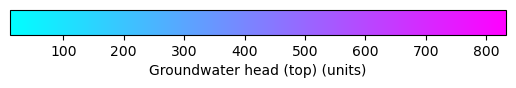

In [29]:
blue_cmap = plt.cm.get_cmap('cool')

fig = plt.figure()
plt.imshow(np.random.random((10,10))*(np.nanmax([np.nanmax(wet_filtered_array),np.nanmax(base_filtered_array),np.nanmax(dry_filtered_array)])),origin='lower',cmap=blue_cmap,interpolation='nearest')
cbar_blue = plt.colorbar(orientation='horizontal')
ax = plt.gca()        
ax.remove()
cbar_blue.ax.set_xlabel('Groundwater head (top) (units)')

plt.savefig('head.png',bbox_inches='tight')

plt.show()


In [30]:
# def parquet_cmaps_and_legend(gdf):
#     sfo_realisations = list(gdf)
#     sfo_realisations.remove('geometry')
#     gdf_realisations = gdf[sfo_realisations]
#     gdf['mean'] = gdf_realisations.mean(axis=1)
    
#     min_value = gdf_realisations.mean(axis=1).quantile(0.05)
#     max_value = gdf_realisations.mean(axis=1).quantile(0.95)
    
#     # Create colourmap
#     colormap = plt.get_cmap('seismic')  # You can replace 'YlOrRd' with any other colormap available in matplotlib
#     # Define custom tick positions and colors
#     tick_positions = [min_value,0, max_value]  # Replace with your desired tick values

#     values = np.linspace(0, 1,len(tick_positions))
#     colors = [plt.cm.colors.to_hex(colormap(value)) for value in values]  # Replace with your desired colors corresponding to tick positions

#     # Create a LinearColormap with custom tick positions and colors
#     custom_colormap = LinearColormap(colors, index=tick_positions, vmin=min_value, vmax=max_value)
#     custom_colormap.caption = 'SFX'  # Set the legend title
    
#     # Create legend
#     legend_html = '''
#     <div style="position: fixed;
#                 bottom: 50px;
#                 left: 50px;
#                 width: 500px;
#                 height: 50;
#                 border:2px solid grey;
#                 background-color: white;
#                 z-index: 1000;
#                 padding: 10px;
#                 opacity: 0.7;
#                 font-size:12px;
#                 ">
#     '''

#     legend_html += custom_colormap._repr_html_()

#     legend_html += '''
#     </div>
#     '''

#     # Create a Popup containing the custom Element content
#     popup_content = folium.Popup(folium.Element(legend_html), parse_html=True)
    
#     return(custom_colormap,popup_content,gdf)


In [31]:
realisations = list(gdf_base_sfo)
realisations.remove('geometry')
gdf_realisations_base = gdf_base_sfo[realisations]
gdf_base_sfo['mean'] = gdf_realisations_base.mean(axis=1)

realisations = list(gdf_wet_sfo)
realisations.remove('geometry')
gdf_realisations_wet = gdf_wet_sfo[realisations]
gdf_wet_sfo['mean'] = gdf_realisations_wet.mean(axis=1)

realisations = list(gdf_dry_sfo)
realisations.remove('geometry')
gdf_realisations_dry = gdf_dry_sfo[realisations]
gdf_dry_sfo['mean'] = gdf_realisations_dry.mean(axis=1)

In [76]:
min_value = 0#gdf_realisations.mean(axis=1).quantile(0.05)
max_value = np.max([gdf_dry_sfo['mean'].max(),gdf_base_sfo['mean'].max(),gdf_wet_sfo['mean'].max()])

colormap = plt.get_cmap('autumn')  # You can replace 'YlOrRd' with any other colormap available in matplotlib
gdf_dry_sfo['mean_norm'] = gdf_dry_sfo['mean']/(max_value)
gdf_base_sfo['mean_norm'] = gdf_base_sfo['mean']/(max_value)
gdf_wet_sfo['mean_norm'] = gdf_wet_sfo['mean']/(max_value)


In [ ]:
# blue_cmap = plt.cm.get_cmap('Blues')
# orange_cmap = plt.cm.get_cmap('Reds')

# fig = plt.figure()
# plt.imshow(np.random.random((10,10))*1000+1000,origin='lower',cmap=blue_cmap,interpolation='nearest')
# cbar_blue = plt.colorbar(orientation='horizontal')
# plt.imshow(np.random.random((10,10))*100,origin='lower',cmap=orange_cmap,interpolation='nearest')
# cbar_orange = plt.colorbar(orientation='horizontal')
# ax = plt.gca()        
# ax.remove()
# cbar_blue.ax.set_xlabel('Monthly mean precipitation (mm)')
# cbar_orange.ax.set_xlabel('Increased Risk of Campylobacter (%)')
# plt.savefig('precip_legend.png',bbox_inches='tight')

In [94]:
custom_colormap

In [33]:
# name = 'Surface to Groundwater Flux'
# fg2 = folium.FeatureGroup(name= lgd_txt.format( txt=name, col= 'Blue'))
# custom_colormap,popup_content,gdf = create_colourmap_and_legend(gdf_base_sfx)
# folium.GeoJson(
#     gdf,
#     name='geojson',
#     style_function=style_function_2
# ).add_to(fg2)
# popup_content.add_to(fg2)
# map_osm.add_child(fg2)

In [91]:
def style_function_2(feature):
    # Replace 'your_color_column' with the actual column name you want to use for color mapping
    color_value = feature['properties']['mean_norm']
    color = colormap(color_value)
    hex_color = mcolors.rgb2hex(color)
    return {
        'color': hex_color,  # Apply the colormap to the line_color
        'weight': 2,      # Adjust line weight as needed
        'opacity': 1
    }

In [93]:

token = "pk.eyJ1Ijoic2hhbm5vbi1iZW5ndHNvbiIsImEiOiJja3F1Y2Q0dHEwMzYwMm9wYmtzYzk2bDZuIn0.5jGMyEiJdmXs1HL7x3ThPw" # your mapbox token
tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)
location = [-39.455244, 176.720952]
map_osm = folium.Map(location=location, zoom_start=9)
custom_tile_layer = folium.TileLayer(tiles=tileurl, name='Satellite',attr='Mapbox').add_to(map_osm)

lgd_txt = '<span style="color: {col};">{txt}</span>'


name = 'Dry'
fg1 = folium.FeatureGroup(name= lgd_txt.format( txt=name, col= 'Red'))
folium.GeoJson(
    gdf_dry_sfo,
    name='geojson',
    style_function=style_function_2
).add_to(fg1)
folium.raster_layers.ImageOverlay(blue_cmap(normalised_dry_array),
                                  [[xr_dry_regrid.y.values.min(), xr_dry_regrid.x.values.min()],
                                   [xr_dry_regrid.y.values.max(), xr_dry_regrid.x.values.max()]],opacity=0.5).add_to(fg1)

name = 'Base'
fg2 = folium.FeatureGroup(name= lgd_txt.format( txt=name, col= 'Black'))
folium.GeoJson(
    gdf_base_sfo,
    name='geojson',
    style_function=style_function_2
).add_to(fg2)
folium.raster_layers.ImageOverlay(blue_cmap(normalised_base_array),
                                  [[xr_base_regrid.y.values.min(), xr_base_regrid.x.values.min()],
                                   [xr_base_regrid.y.values.max(), xr_base_regrid.x.values.max()]],opacity=0.5).add_to(fg2)

name = 'Wet'
fg3 = folium.FeatureGroup(name= lgd_txt.format( txt=name, col= 'Blue'))
folium.GeoJson(
    gdf_wet_sfo,
    name='geojson',
    style_function=style_function_2
).add_to(fg3)
folium.raster_layers.ImageOverlay(blue_cmap(normalised_wet_array),
                                  [[xr_wet_regrid.y.values.min(), xr_wet_regrid.x.values.min()],
                                   [xr_wet_regrid.y.values.max(), xr_wet_regrid.x.values.max()]],opacity=0.5).add_to(fg3)


map_osm.add_child(fg1)
map_osm.add_child(fg2)
map_osm.add_child(fg3)


##########

# Define the HTML content for the button (you can customize the appearance and behavior here)
button_html = """
<div style="position: fixed; bottom: 10px; left: 10px; z-index: 1000; background-color: white; padding: 10px; border: 1px solid gray;">
    <a href="https://exchange.iseesystems.com/public/nicolamcdonald/deepsouthinterfacedraft" target="_blank"><button style="cursor:pointer;">Back to systems diagram</button></a>
</div>
"""

# Inject the custom HTML element into the map's HTML representation
map_osm.get_root().html.add_child(folium.Element(button_html))


###################

# Define the HTML content for the popup (you can customize the appearance and content here)
popup_html = """
<div style="position: fixed; bottom: 10px; right: 10px; z-index: 1000;width: 200px; height: 100px; background-color: white; border: 1px solid black; text-align: center;">
    <p>This is a custom popup</p>
    <p>This is for some explanation of the diagram.</p>
</div>
"""

map_osm.get_root().html.add_child(folium.Element(popup_html))


legend_html = """
<div style="position: fixed; bottom: 15px; right: 600px; z-index: 1000;width: 500px; height: 175px; background-color: white; border: 1px solid black; text-align: center;">
    <img src="{}" alt="Custom Image Overlay" width="450">
</div>
""".format("head.png")

map_osm.get_root().html.add_child(folium.Element(legend_html))

#######################

folium.LayerControl(name='Ground Water Output').add_to(map_osm)   

map_osm.save('groundwater.html')

In [90]:
gdf_wet_sfo

realization,132,base,12,15,42,81,115,141,144,147,...,190,193,194,195,196,197,198,geometry,mean,mean_norm
rno,,,,,,,,,,,,,,,,,,,,,
0,123.837269,59.101708,1.296324,605.792751,0.908896,74.453524,25.266492,71.179071,68.910513,31.150532,...,36.999516,255.173066,120.585887,12.362388,-0.000000,159.964558,55.686903,"MULTILINESTRING ((176.72730 -39.69589, 176.726...",138.089157,0.000048
1,293.383663,216.108165,77.770855,1099.266382,131.846728,179.482478,61.800198,190.823215,140.264057,136.024066,...,119.731191,418.045618,199.474010,213.280072,1.332351,310.506709,213.544266,"MULTILINESTRING ((176.72609 -39.69503, 176.726...",311.870316,0.000109
10,6593.367660,2394.425235,139.074771,5535.725134,30965.895710,1248.944260,543.405252,6714.831450,806.782970,155.893476,...,462.286411,1826.791114,3361.213225,27295.416280,7800.338558,144657.268300,2942.679062,"MULTILINESTRING ((176.73802 -39.67843, 176.738...",17152.754956,0.006001
100,1354.349592,948.322758,1488.522713,1516.937619,5485.205883,611.739626,43.582671,813.773471,707.516746,1110.524390,...,397.905288,458.796959,382.131802,329.020050,616.802166,91.176726,685.994736,"MULTILINESTRING ((176.81260 -39.69942, 176.812...",1138.807482,0.000398
1000,154.063494,114.434744,200.892770,166.550322,98.869419,127.559287,329.151757,169.713644,59.608675,302.768052,...,51.775699,530.135683,174.013099,141.073270,56.123260,160.236786,72.976221,"MULTILINESTRING ((176.89514 -39.52916, 176.893...",187.800242,0.000066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,332.448672,644.123699,2625.588744,1664.272003,2206.400613,524.190324,2400.056887,3408.215878,2122.473846,660.465731,...,2446.094669,260.621638,714.842855,484.392283,167.074758,339.914578,1789.446150,"MULTILINESTRING ((176.84545 -39.55603, 176.846...",1167.857181,0.000409
996,413.970871,806.190224,3401.224394,2033.298300,2917.322986,685.774870,3058.496779,4090.383683,2600.081339,778.461233,...,3326.991143,415.159870,910.848605,616.723929,222.361421,430.059562,2134.959145,"MULTILINESTRING ((176.84662 -39.55599, 176.846...",1499.249436,0.000525
997,-0.000000,-0.000000,390.646268,-0.000000,-0.000000,13.257568,-0.000000,6.831131,-0.000000,32.312527,...,-0.000000,124.639650,25.369458,20.780456,-0.000000,55.628926,71.071241,"MULTILINESTRING ((176.84662 -39.55599, 176.846...",64.286559,0.000022


# make continuous

In [46]:
gdf_dry_sfo['mean']

rno
0          22.524328
1          66.733908
10      14335.389088
100       608.726041
1000       30.413082
            ...     
995       898.888039
996      1159.515373
997        26.896770
998        12.334347
999        22.745249
Name: mean, Length: 5405, dtype: float64